*   Nama : Tuti Amalia 
*   Email : amalia_tuti111@gmail.com
*   Asal : Kabupaten Gowa, Sulawesi Selatan

In [1]:
# library
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import shutil
import random


In [2]:
# download dataset yang akan digunakan
!wget https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip -P /tmp


--2021-07-25 14:58:04--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip.3’

rockpaperscissors.z 100%[===================>] 307.92M  10.3MB/s    in 38s     

2021-07-25 14:58:43 (8.00 MB/s) - ‘/tmp/rockpaperscissors.zip.3’ saved [322873683/322873683]



In [3]:
# melakukan ekstraksi pada file zip
import zipfile,os
fileZip = '/tmp/rockpaperscissors.zip'
zipRef = zipfile.ZipFile(fileZip, 'r')
zipRef.extractall('/tmp')
zipRef.close()

In [7]:
# melihat total gambar pada masing2 folder
base_dir = '/tmp/rockpaperscissors/'
class_dir = ['paper', 'rock', 'scissors']

for i in class_dir:
    print('Total gambar {} : '.format(i) + str(len(os.listdir(base_dir + i + '/'))))

Total gambar paper : 712
Total gambar rock : 726
Total gambar scissors : 750


In [8]:
# membuat nama direktori
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir, 'val')

# membuat direktori train dan validation
os.makedirs(train_dir, exist_ok = True)
os.makedirs(val_dir, exist_ok = True)

In [10]:
# untuk memisahkan training set dan validation set
for i in class_dir:
  train_file_names, val_file_names =  train_test_split(os.listdir(os.path.join(base_dir, i)), test_size = 0.4)
  train_class_dir = os.path.join(train_dir, i)
  val_class_dir = os.path.join(val_dir, i)

  # Jika folder ini ada, hapus isinya supaya tidak terjadi penumpukan data ketika dieksekusi berkali2
  if os.path.exists(train_class_dir):
    shutil.rmtree(train_class_dir)

  if os.path.exists(val_class_dir):
    shutil.rmtree(val_class_dir)

  # buat folder baru
  os.makedirs(train_class_dir, exist_ok = True)
  os.makedirs(val_class_dir, exist_ok = True)
  
  # copy isinya dari folder lama ke folder baru
  for tfn in train_file_names:
    shutil.copy(os.path.join(base_dir + i, tfn), train_class_dir)

  for vfn in val_file_names:
    shutil.copy(os.path.join(base_dir + i, vfn), val_class_dir)

  #melihat jumlah masing2 kelas untuk train dan validation
  print('Gambar untuk train {} : {}'.format(i,str(len(os.listdir(train_class_dir)))))
  print('Gambar untuk validasi {} : {}'.format(i,str(len(os.listdir(val_class_dir)))))
  print('\n')

Gambar untuk train paper : 427
Gambar untuk validasi paper : 285


Gambar untuk train rock : 435
Gambar untuk validasi rock : 291


Gambar untuk train scissors : 450
Gambar untuk validasi scissors : 300




In [11]:
# implementasi image data generator untuk augmentasi gambar
trainDatagen = ImageDataGenerator(
                    rescale = 1./225,
                    rotation_range = 20,
                    horizontal_flip = True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

testDatagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = trainDatagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
  
validation_generator = testDatagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [13]:
#membuat model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150, 150, 3), strides=1),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', strides=1),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(), 
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

In [14]:
# menggunakan callback
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('val_accuracy') > 0.99):
      print('Akurasi telah mencapai 99%')
      self.model.stop_training = True

callbacks = CustomCallback()

In [15]:
# Compile model
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Compiling Model.......')

Compiling Model.......


In [16]:
import datetime
start = datetime.datetime.now()

history = model.fit(
      train_generator,
      steps_per_epoch = 20,
      epochs = 25,
      validation_data = validation_generator,
      validation_steps = 3,
      callbacks = callbacks,
      verbose = 1)

end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/25
20/20 [==============================] - 33s 2s/step - loss: 1.0955 - accuracy: 0.3797 - val_loss: 1.0801 - val_accuracy: 0.4062
Epoch 2/25
20/20 [==============================] - 32s 2s/step - loss: 1.0008 - accuracy: 0.5375 - val_loss: 0.9059 - val_accuracy: 0.5938
Epoch 3/25
20/20 [==============================] - 32s 2s/step - loss: 0.8057 - accuracy: 0.6859 - val_loss: 0.5536 - val_accuracy: 0.8958
Epoch 4/25
20/20 [==============================] - 32s 2s/step - loss: 0.5140 - accuracy: 0.8297 - val_loss: 0.4201 - val_accuracy: 0.8646
Epoch 5/25
20/20 [==============================] - 32s 2s/step - loss: 0.4419 - accuracy: 0.8516 - val_loss: 0.5415 - val_accuracy: 0.8229
Epoch 6/25
20/20 [==============================] - 32s 2s/step - loss: 0.3621 - accuracy: 0.8813 - val_loss: 0.2622 - val_accuracy: 0.9167
Epoch 7/25
20/20 [==============================] - 32s 2s/step - loss: 0.2877 - accuracy: 0.9062 - val_loss: 0.1610 - val_accuracy: 0.9583
Epoch 8/25
20/20 [==

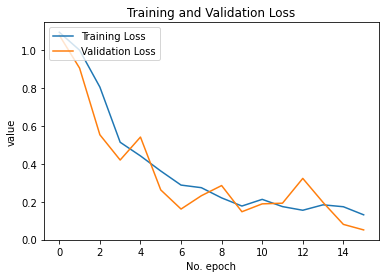

In [17]:
from matplotlib import pyplot as plt
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

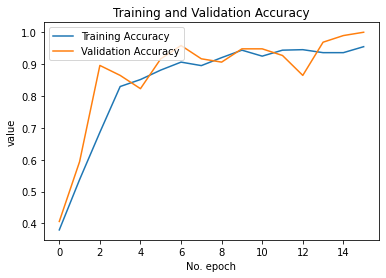

In [20]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Saving tuti_scissors2-removebg-preview.png to tuti_scissors2-removebg-preview.png
tuti_scissors2-removebg-preview.png
scissors


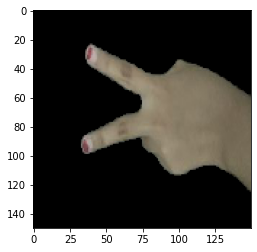

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')

Saving tuti_rock2-removebg-preview.png to tuti_rock2-removebg-preview.png
tuti_rock2-removebg-preview.png
rock


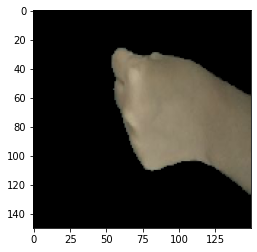

In [22]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')

Saving tuti_paper2-removebg-preview.png to tuti_paper2-removebg-preview.png
tuti_paper2-removebg-preview.png
paper


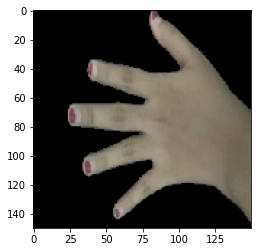

In [23]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')